In [4]:
import numpy as np
from scipy import signal, misc, ndimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Computer Vision - Features and Descriptors

## Lecture 2: Linear Diffusion, Gaussian Convolution and Pyramids

### Linear Diffusion
General Difuson equation
$$
    \partial_t u = div(D.\nabla u) = \nabla^T ( D.\nabla u )
$$
For linear case $D=1$
$$
    \partial_t u = \nabla^T \nabla u = \Delta u = \partial_{xx} u + \partial_{yy} u
$$
with boundary/initial coditions
$$
    u(x,y,t=0) = f(x,y) \\
    \partial_n u =n^T \nabla u = 0
$$

Solving PDE:
$$
\begin{aligned}
\partial_{t} u &=\frac{u_{i, j}^{k+1}-u_{i, j}^{k}}{\tau}+O(\tau) \\
\partial_{x x} u &=\frac{u_{i+1, j}^{k}-2 u_{i, j}^{k}+u_{i-1, j}^{k}}{h_{1}^{2}}+O\left(h_{1}^{2}\right)
\end{aligned}
$$

### Gaussian Convolution
Grey-scale image be represented by a bounded function $f: \Omega \rightarrow \mathbb R$, with image domain $\Omega:=(0,a_1)\times(0,a_2)$

Convolution:
$$
    \left(K_{\sigma} * f\right)(\boldsymbol{x}):=\int_{\mathbb{R}^{2}} K_{\sigma}(\boldsymbol{y}) f(\boldsymbol{x}-\boldsymbol{y}) d \boldsymbol{y}
$$

Gaussian Kernel
$$
   K_{\sigma}(\boldsymbol{x}):= \frac{1}{\sigma \sqrt{2 \pi}}  \exp \left(-\frac{|\boldsymbol{x}|^{2}}{2 \sigma^{2}}\right), \quad\quad \left(\mathcal{F} K_{\sigma}\right)(\boldsymbol{\omega})=\exp \left(-\frac{|\boldsymbol{\omega}|^{2}}{2 / \sigma^{2}}\right)
$$
Gaussian convolution attenuates high frequencies exponentially $\rightarrow$ it is a low-pass filter

<br>

Analytical solution for linear diffusion is a gaussian convolution:
$$
    u(\boldsymbol{x}, t)=\left\{\begin{array}{ll}
    {f(\boldsymbol{x})} & {(t=0)} \\
    {\left(K_{\sqrt{2 t}} * f\right)(\boldsymbol{x})} & {(t>0)}
    \end{array}\right.
$$
Relation between diffusion time and kernel width: $t = \dfrac{1}{2}\sigma^2$ or $\sigma=\sqrt{2t}$

Gaussian smoothing (i.e. linear diffusion) creates a scale-space. Small objects tend to have high frequencies, which will vanish first. Big objects, usually composed of low frequencies will only vanish in large scales

#### Numerical Aspects
- Time-domain convolution: sample Gaussian and truncate at $3\sigma$. Good for small kernel sizes $\sigma$
- Frequency-domain convolution: good for big kernel sizes
- Discretization of diffusion equation: less efficient for large diffusion times but can be also applied to nonlinear PDEs.

In [5]:
def linearDiffusion(img,sigma=1,tau=0.1,hx=1,hy=1):
    hx = hy = 1
    tau = 0.25
    t = 0.5*sigma**2
    kernel = np.array([[0, tau/hy**2, 0],[tau/hx**2, 1-2*tau/hx**2-2*tau/hy**2, tau/hx**2],[0, tau/hy**2, 0]])
    for t in np.arange(0,t,tau):
        img = signal.convolve2d(img, kernel, boundary='symm', mode='same')
    return img

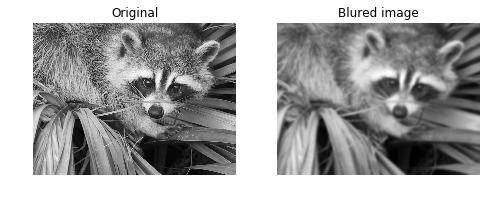

In [7]:
# img = mpimg.imread('./images/sbrain.pgm') 
img = misc.face(gray=True).astype(np.float32)
grad = linearDiffusion(img, sigma=5)

fig, (ax_orig, ax_conv) = plt.subplots(1,2, figsize=(8,10))
ax_orig.imshow(img, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_conv.imshow(np.absolute(grad), cmap='gray')
ax_conv.set_title('Blured image')
ax_conv.set_axis_off()
fig.show()

### Gaussian Pyramids (Low pass filter)

**Idea:** Image representation on multiple resolution level <br>
**How:** Smooth image with a low pass and then sample with half of the frequency <br>
**Why:** Solving problems in a coarse-to-fine manner accelerates most algorithms

Gaussian pyramids are much more memory efficient than discrete scale spaces
due to the downsampling step in the multiresolution representation

### Laplacian Pyramids (Band pass decomposition)

Alternative to Fourrier analysis <br>
Decompose an image in its spatial domain in different frequency bands <br>

Subtract levels in the image pyramids. <br>
To subtract images of equal size, interpolate the downsampled image by upscale by pixel doubling or binomial kernel $[1/4,1/2,1/4]$

<br><br><br>
## Lecture 3: Edge and Corner Detection

### Derivative Filters

A strong change in grey value (derivative) indicates an edge

- First order derivative (central difference) $$\quad\partial_x \approx \frac{1}{2h} [-1,0,1]  + \mathcal O(n^2)$$
- Sobol operator (perpendicular smoothing) $$\quad\partial_x \approx \frac{1}{4}\left[\begin{matrix}1\\2\\1\end{matrix}\right] * \frac{1}{2h} [-1,0,1] = \dfrac{1}{8h} \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}$$ 

### Edge Detection

- Convolve the image with a gaussian filter to attenuate high frequencies $u = K_{\sigma}*f$
- Calculate gradient magnitude $\nabla u = \left|\ \begin{matrix} \partial_x u \\ \partial_y u  \end{matrix}\right|$ 
- Extract image edges where gradient magnitude execeds some threshold T

One might choose the threshold T as the 0.8 quantile of the gradient magnitude histogram for all pixels

Advantages:
- Robust against noise

Disadvantages:
- Need to choose threshold and pre-smoothing parameter
- Does not generates closed contours
- Some edges are too thick and some are below threshold

Extension to colored images (at least one channel should contribute with a large gradient)
$$\left|\left(\begin{array}{c}{\nabla f_{1}} \\ {\nabla f_{2}} \\ {\nabla f_{3}}\end{array}\right)\right| > T_1$$

### Canny Edge Detector

- **Step 1:** (Gradient approximation) <br>
    Compute pixel-wise gradient magnitude $|\nabla u|$ and orientation angle $arg(\nabla u)$. Select edges where $|\nabla u|>T_1$

- **Step 2:** (Nonmaxima suppresion) Thin edges to 1 pixel <br>
    Mark pixels, which have neighbors with greater gradient magnitude in the orthogonal edge direction. Thereafter remove all the marked pixels 

- **Step 3:** (Hysteresis Thresholding) Select only relevant edges <br>
    Select pixel seeds that are above a upper threshold $T_2$. Add all the neighboring pixels that are above a lower thershold $T_1$

### Laplacian of Gaussian

- Perform Gaussian smoothing on image $u = K_\sigma * f$
- Compute the Laplacian $\Delta u = u_{xx} + u_{yy}$
- Identify edges as the zero-crossing (change of signal) of the Laplacian (second-order derivative)

Advantages:
- Closed contours with minimal width
- No additional paramters (besides $\sigma$)

Disadcantages
- Sensitive to noise
- False maxima (detect also minima and not only maxima)

Second order derivative approximation (central differences)
$$ \partial_{xx} \approx \dfrac{1}{h^2}\begin{bmatrix} 1 & -2 & 1 \end{bmatrix} + \mathcal O(n^2) $$
$$ \Rightarrow \Delta u = u_{xx} + u_{yy} = \dfrac{1}{h^2}\begin{bmatrix} 1 & -2 & 1 \end{bmatrix} + \dfrac{1}{h^2}\begin{bmatrix} 1 \\ -2 \\ 1 \end{bmatrix} = \dfrac{1}{h^2} \begin{bmatrix} 0&1&0 \\ 1&-4&1 \\ 0&1&0 \end{bmatrix}$$

### Corner Detection

Structure tensor
$$J_{\rho}=K_{\rho} *\left(\nabla f \nabla f^{\top}\right)=\left(\begin{array}{cc}{K_{\rho} * f_{x}^{2}} & {K_{\rho} * f_{x} f_{y}} \\ {K_{\rho} * f_{x} f_{y}} & {K_{\rho} * f_{y}^{2}}\end{array}\right)$$

Do eigendecomposition
- Corner: $\lambda_1, \lambda_2 >> 0$
- Edge in $e_2$ direction: $\lambda_1>>0, \lambda_2 \approx 0$
- Flat area: $\lambda_1\approx 0, \lambda_2 \approx 0$

Extension to colored images:
$$J_{\rho} = \sum_{i={r,g,b}} K_{\rho} *\left(\nabla f_i \nabla f_i^{\top} \right) $$

<br><br><br>
## Lecture 4: Hough Transform, Invariants

### Hough Transform

**Goal** Detect simple geomtric objects that can be represented by a few parameters

Line: $x cos\phi + y sin\phi - d = 0$

Circle: $(x-a)^2 + (y-b)^2 - r^2 = 0$

- **Step 1**: discretize parameter space and initialize the grid with zeros
- **Step 2**: for every edge pixel ($|\nabla u|>T_1$), add a vote for its possible parameters
- **Step 3**: Select parameters with most votes

Advantages:
- Can detect objects even if they are partially occluded
- Robust and also possible to be used to detect non-parametric objects

Disadvantages:
- Bad scalability with the number of parameters (requires lots of memory)
- Corse-to-fine approach might help to address this problem



### Invariants

**Goal** check if one image object has correspondence on the second image, given that the second image might have been subject to translations, rotations, scalings, ilumination changes, etc. 

#### Moment Invariants

Alternative description of images, moments instead of grey values 
$$ m_{p, q}:=\sum_{i=1}^{N} \sum_{j=1}^{M} i^{p} j^{q} f_{i, j} $$
Problems: not invariant at all

#### Translation Invariants (central moments)
$$ \mu_{p, q}:=\sum_{i=1}^{N} \sum_{j=1}^{M} (i-\bar i)^{p} (j-\bar j)^{q} f_{i, j} $$
where $\bar i = m_{1,0}/m_{0,0}$

#### Scale Invariants (normalised central moments)
$$ \eta_{p,q} =  \frac{\mu_{p,q}}{\mu^\gamma_{0,0}}$$
with $\gamma=\frac{p+q}{2}+1$

#### Rotation Invariants (seven moments of Hu)
Hu has derived 7 moment invariants as combinations of normalised central moments such that they are also invariant under rotations (besides translation and scaling)

There are also alternatives that are invariant under affine transformations and linear motion blur.

Discretization effects are the reason why these invariances are never fully invariant in practice.

#### Photometric Invariants

Classification of illumination changes:

1. Global multiplicative changes
2. Local multiplicative changes: shadow, shading
3. Local additive changes: highlights, specular reflections

Chromaticity Space (1,2): (R,G,B) \righarrow (R/N,G/N,B/N), with N:=1/3*(R+G+B)

HSV Colour Space (Hue, Saturation, Value/Brightness): The Hue component is invariant under (1,2,3). For example, shadows are usually only visible in the V channel

<br><br><br>
## Lecture 5: Texture Analysis/Discrimination

**Goal:** discriminate two textures 

#### Texture discrimination - First order statistics (does not considers spatial context)


##### Statistical Moments

Central moment of order k of N pixels with grey values $f_1,\dots,f_N$ and mean $\mu$. Alternatively it can also be infered from the histogram with probabilities $p(z_i)$ for different grey values $z_i$
$$ M_k = \frac{1}{N} \sum^N_{i=1}(f_i-\mu)^k = \sum^L_{i=1}(z_i-\mu)^k p(z_i)$$

Variance (k=2):
$ M_{2} = \frac{1}{N} \sum_{i=1}^N (f_i - \mu)^2  =  \sigma^2 $

Skewness (k=3)
$ M_{3} = \frac{1}{N} \sum_{i=1}^N (\frac{f_i - \mu}{\sigma})^3  =  V $

Kurtosis (k=4)
$ M_{3} = \frac{1}{N} \sum_{i=1}^N (\frac{f_i - \mu}{\sigma})^4 -3  =  V $

##### Procedure:
1. Replace every grey value by statistical moments within some window
2. Apply a classical edge detector to the resulting image

##### Problems:
- If it is used as a global descriptor, then the spatial ordering of the pixels will not matter (a chessboard has the same descriptor as a half-black half-white board)

<br><br>

#### Texture discrimination - Second order statistics (considers spatial context)


**Idea 1:** Analyse statistical moments on different scales of the pyramid.

**Idea 2:** Coocurrence Matrices (histogram of neighborhood relations)

1. Define a displacement vector $d=[d_1,d_2]^T$ that identifies a pair of points to be compared
2. Create histogram of grey value pairs, i.e. calcute the frequency that a certain grey value $i$ appears together with some other grey value $j$ in direction $d$

How to characterize textures using the Coocurrence Matrix?

**Mode**: $argmax_{i,j} \; p_{i,j}$

**Contrast**: $\sum_{i, j}(i-j)^{2} p_{i, j}$

**Homogeneity**: $\sum_{i, j} \frac{p_{i, j}}{1+|i-j|}$

**Entropy**: $-\sum_{i, j} p_{i, j} \log p_{i, j}$


**Idea 3:** Analysis in Fourier Domain

$$ g(r):=\int_{0}^{2 \pi}|\hat{f}(r, \phi)| d \phi $$
$$h(\phi):=\int_{0}^{R}|\hat{f}(r, \phi)| d r$$

can help to characterize radial behaviour and the angular dependency in the Fourier spectrum

<br><br><br>
## Lecture 6: SIFT

**Goal:** 

1. Detect characteristic points in images (mainly corners). 
2. Ensure invariance w.r.t. changes in location, scale and orientation
<br>
<br>

**Steps:**

1. Detection of characteristic feature points
2. Accurate localisation of key points
3. Assignment of the dominant orientation
4. Computation of a suitable key point descriptor

### 1. Detection of characteristic feature points (detection of scale-space extrema)

Compute scale-space Laplacian pyramid (decompose an image in its spatial domain in different frequency bands)

Each Gaussian scale-space is computed as 
$ D_\sigma^k f := T_{k\sigma} f - T_\sigma f $, with $k>1$

Find maximum in both scale and position

<img src="./images/SIFT01.png" width=400>


### 2. Accurate localisation of key points (sub pixel refinement)

Perform second-order Taylor expansion (polynomial fit) around each feature point $x_i=(x_i,y_i,\sigma_i)^T$ (space-scale). Use finite diferences to approximate the derivative and hessian matrix

$$ D\left(\boldsymbol{x}_{i}+\boldsymbol{h}\right) \approx D\left(\boldsymbol{x}_{i}\right)+\nabla D\left(\boldsymbol{x}_{i}\right)^{\top} \boldsymbol{h}+\frac{1}{2} \boldsymbol{h}^{\top} \mathcal{H}\left(D\left(\boldsymbol{x}_{i}\right)\right) \boldsymbol{h} $$

$$ \nabla_{h}D(x_i+h) = 0 \Rightarrow \boxed{h = - \mathcal H ^{-1}(x_i) \nabla D(x_i)} $$

Accuracy will be improved in both scale and location

Next, we remove unreliable feature points which have extremal value below a threshold or if we have edge instead of corner (one Hessian eigenvalue is close to zero)

### 3. Assignment of the dominant orientation

Compute Histogram of Gradients (HoG) for the neighborhood ($3\sigma$) of each feature point $x_i=(x_i,y_i,\sigma_i)$.

Estimate the dominant direction as the orientation mode

### 4. Computation of a suitable key point descriptor

Divide neighborhood into 16 square-blocks of size 4x4 each, rotated according to the dominant orientation.

Compute gradient histogram (8 bins covering 45 degrees)

<img src="./images/SIFT02.png" width=400>

Final descriptor is a vector of size 128, which is normalized by its magnitude


### Why is SIFT so popular?

- Invariant under scalings, rotations, shifts and rotations
- Invariant under affine illumination changes (gradient information)


# Computer Vision - Optical Flow

<br><br><br>
## Lecture 7: Local Methods

**Goal:**  Given an image sequence $f(x,y,t)$, find a displacement vector field (optical flow) between images $u(x,y,z)$ and $v(x,y,z)$

### Grey Value Constancy assumption

$$ f(x,y,z) = f(x+u,y+v,z+1) $$

Which can be linearized as:
$$ f(x+u,y+v,z+1) \approx f(x,y,z) + u\cdot f_x + v\cdot f_y + f_z $$

and the new grey value constancy assumption (OFC) becomes:
$$ u\cdot f_x + v\cdot f_y + f_z = 0 $$

### Aparture Problem

The OFC equation gives us one equation and two unkowns $u,v$ to solve.

WE can only solve the flow component that is parallel to the spatial gradient

$$ f_x u + f_y v + f_z = \begin{bmatrix}u\\v\end{bmatrix}^T \nabla f + f_z = 0 $$

This means that additional flow orthogonal to $\nabla f^\perp$ without violating the OFC

The normal flow can be rewriten as:
$$ \left( \begin{array}{l} u_{n} \\ v_{n} \end{array} \right) = \left[\left(\begin{array}{l} u \\ v \end{array}\right)^T \frac{\nabla f}{|\nabla f|}\right] \frac{\nabla f}{|\nabla f|} = -\frac{f_{z}}{|\nabla f|} \frac{\nabla f}{|\nabla f|} $$

### Lucas and Kanade

**Goal:** Minimize the local energy within some neighborhood $B_\rho(x_0,y_0)$ of radius $\rho$:

$$E(u, v)=\frac{1}{2} \int_{B_{\rho}\left(x_{0}, y_{0}\right)}\left(f_{x} u+f_{y} v+f_{z}\right)^{2} dx dy$$

Next, computing partial derivatives w.r.t. $u$ and $v$ gives:
$$ \frac{\partial E}{\partial u}=\int_{B_{\rho}} f_{x}\left(f_{x} u+f_{y} v+f_{z}\right) d x d y \stackrel{!}{=} 0 $$
$$ \frac{\partial E}{\partial v}=\int_{B_{\rho}} f_{y}\left(f_{x} u+f_{y} v+f_{z}\right) d x d y \stackrel{!}{=} 0 $$

writing in matrix form:
$$\left(\begin{array}{cc}\int_{B_{\rho}} f_{x}^{2} d x d y & \int_{B_{\rho}} f_{x} f_{y} d x d y \\ \int_{B_{\rho}}^{2} f_{x} f_{y} d x d y & \int_{B_{\rho}} f_{y}^{2} d x d y\end{array}\right)\left(\begin{array}{c}u \\ v\end{array}\right)=\left(\begin{array}{c}-\int_{B_{\rho}} f_{x} f_{z} d x d y \\ -\int_{B_{\rho}} f_{y} f_{z} d x d y\end{array}\right)$$

Next we can replace the "hard" window $B_\rho$ by a smooth convolution with a Gaussian $K_\rho$
$$ J_{\rho} \left(\begin{array}{c}u \\ v\end{array}\right) = \left(\begin{array}{cc}{K_{\rho} * f_{x}^{2}} & {K_{\rho} * f_{x} f_{y}} \\ {K_{\rho} * f_{x} f_{y}} & {K_{\rho} * f_{y}^{2}}\end{array}\right) \left(\begin{array}{c}u \\ v\end{array}\right) = \left(\begin{array}{l} -K_{\rho} *\left(f_{x} f_{z}\right) \\ -K_{\rho} *\left(f_{y} f_{z}\right) \end{array}\right) $$

where $J_\rho$ is the Structure Tensor

The Lucas-Kanade method solves a $2\times2$ linear system of equations for each pixel.

Lucas-Kanade assumes a constant displacement withing a local neighbourhood

**Note:**
- rank($J_\rho$)=2: Corner. Full flow be computed, since $J_\rho$ is full rank.
- rank($J_\rho$)=1: Edge. Aperture problem. One can only compute the normal flow. 
- rank($J_\rho$)=0: Flat area. No flow can be determined in this case.

** Advantages **:
- Simple and fast to compute

** Disadvantages **:
- Does not allow flow field computation at all locations
- Does not work at non-translatory motion and at flow discontinuities

### The Approach of Biguen (Total Least Squares)

The energy function can be written as:
$$E(\tilde{\boldsymbol{w}})=\int_{B_{\rho}\left(x_{0}, y_{0}\right)}\left(f_{x} \tilde{w}_{1}+f_{y} \tilde{w}_{2}+f_{z} \tilde{w}_{3}\right)^{2} d x d y$$

with $u=\frac{\tilde{w}_{1}}{\tilde{w}_{3}}, \quad v=\frac{\tilde{w}_{2}}{\tilde{w}_{3}}$

which is equal to
$$\begin{aligned} E(\tilde{\boldsymbol{w}}) &:=\int_{B_{\rho}}\left(\tilde{\boldsymbol{w}}^{\top} \nabla_{3} f\right)^{2} d x d y \\ &=\int_{B_{\rho}} \tilde{\boldsymbol{w}}^{\top} \nabla_{3} f \nabla_{3} f^{\top} \tilde{\boldsymbol{w}} d x d y \\ &=\boldsymbol{w}^{\top}\left(\int_{B_{\rho}} \nabla_{3} f \nabla_{3} f^{\top} d x d y\right) \tilde{\boldsymbol{w}} \end{aligned}$$

The vector $w$ that minimizes $E(w)$ is the same as the normalised eigenvector to the smallest eigenvalue of the spatiotemporal structure tensor $J_\rho$:
$$\begin{aligned} J_{\rho} &:=K_{\rho} *\left(\nabla_{3} f \nabla_{3} f^{\top}\right) \\ &=\left(\begin{array}{ccc}K_{\rho} *\left(f_{x}^{2}\right) & K_{\rho} *\left(f_{x} f_{y}\right) & K_{\rho} *\left(f_{x} f_{z}\right) \\ K_{\rho} *\left(f_{x} f_{y}\right) & K_{\rho} *\left(f_{y}^{2}\right) & K_{\rho} *\left(f_{y} f_{z}\right) \\ K_{\rho} *\left(f_{x} f_{z}\right) & K_{\rho} *\left(f_{y} f_{z}\right) & K_{\rho} *\left(f_{z}^{2}\right)\end{array}\right) \end{aligned}$$




**Note:**
- rank($J_\rho$)=3: OFC is violated
- rank($J_\rho$)=2: Full flow be computed, since $J_\rho$ is full rank. In this pixel we have a corner
- rank($J_\rho$)=1: Aperture problem. One can only compute the normal flow. 
- rank($J_\rho$)=0: No flow can be determined in this case.

<br><br><br>
## Lecture 8: Motion Models, Tracking and Feature Matching

### The Affine Lucas and Kanade Method

**Goal:** Instead of restricting all the neighborhood to have the same displacement, we now allow a affine change in the displacement of neighbourhood pixels

Lets consider the following parametrization:

$$\boldsymbol{w}=\left(\begin{array}{c}u \\ v \\ 1\end{array}\right)=\left(\begin{array}{c}a x+b y+c \\ d x+e y+f \\ 1\end{array}\right)=\underbrace{\left(\begin{array}{ccccccc}x & y & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & x & y & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 1\end{array}\right)}_{M} \underbrace{\left(\begin{array}{c}a \\ b \\ c \\ d \\ e \\ f \\ 1\end{array}\right)}_{\boldsymbol{p}}$$

The OFC can then be rewritten as:
$$f_{x} u+f_{y} v+f_{z}=\nabla_{3} f^{\top} \boldsymbol{w}=\nabla_{3} f^{\top} M \boldsymbol{p}=\left(M^{\top} \nabla_{3} f\right)^{\top} \boldsymbol{p}=r^{\top} \boldsymbol{p}$$

And the energy function to be minimized is:
$$\begin{aligned} E(\boldsymbol{p}) &= \int_{B_{\rho}}\left(\boldsymbol{p}^{\top} \boldsymbol{r}\right)^{2} d x d y \\ &= \boldsymbol{p}^{\top}\left(\int_{\boldsymbol{B}_{\rho}} \mathbf{r} \mathbf{r}^{\top} d x d y\right) \boldsymbol{p} \\ &=\boldsymbol{p}^{\top} \hat{J}_{\rho} \boldsymbol{p} \end{aligned}$$

The minimum requires the derivatives w.r.t. all 6 parameters to be zero $\frac{\partial E}{\partial a}, \frac{\partial E}{\partial b}, \dots, \frac{\partial E}{\partial f} = 0$













### The KLT Feature Tracker

1. Select features to be tracked - neighbourhood around corners
2. Compute inter-frame displacements for each feature - Lucas-Kanade method
3. Monitor features at new location - compute cumulative error by evaluating OFC
$\rightarrow$ discard features that could not be tracked
4. Go to (2), but only consider features not discarded in (3) some approaches also allow to add new features at this point

### 1. Feature Selection

Select points by thresholding the smallest eigenvalue of the structure tensor. This comes down to detecting and tracking corners

Perform feature thinning: remove features until feature neighborhood does not overlap anymore 


### 2. Tracking

Here, a nonlinear Lucas-Kanade method is used (with increment linearization and backward-registration), since the linearized OFC is tipically not sufficient for an accurate tracking.

The nonlinear OFC is:
$$\begin{aligned} E\left(u^{k+1}, v^{k+1}\right) &=\int_{B_{\rho}}\left(f\left(x+u^{k+1}, y+v^{k+1}, z+1\right)-f(x, y, z)\right)^{2} d x d y \\ &=\int_{B_{\rho}}\left(f\left(x+u^{k}+d u^{k}, y+v^{k}+d v^{k}, z+1\right)-f(x, y, z)\right)^{2} d x d y \end{aligned}$$

which after linearization of $du^k, dv^k$ becomes:
$$\begin{aligned} E\left(d u^{k}, d v^{k}\right)=\int_{B_{\rho}}(& f_{x}\left(x+u^{k}, y+v^{k}, z+1\right) d u^{k} \\+& f_{y}\left(x+u^{k}, y+v^{k}, z+1\right) d v^{k} \\+&\left.f_{z}\left(x+u^{k}, y+v^{k}, z+1\right)\right) \end{aligned}$$
with initial flow $(u^0, v^0)\top= (0,0)\top$ and update equation
$$\left(u^{k+1}, v^{k+1}\right)^{\top}=\left(u^{k}, v^{k}\right)^{\top}+\left(d u^{k}, d v^{k}\right)^{\top}$$

However, $u^k$ and $v_k$ tipically have subpixel precision, requiring us to perform a interpolation to be able to evaluate $f(x+u^k,y+v^k,z+1)$

<img src="./images/backwardreg.png" width=400>

### 3. Monitoring

**Goal:** Detect when we lose track of a feature. This can be verified by evaluating the OFC violation:

$$ e = \int_{B_\rho} \left( f(x+u,y+v,z+1) - f(x,y,1) \right)^2 dx dy $$

which is computed using an affine Lucas-Kanade motion model, which discriminates much more the errors, making it easier to discard "bad" features. 



